This is a tutorial notebook on how MCMC can be run using Skylens.

In [1]:
import os
os.environ["OMP_NUM_THREADS"] = "4" #need to be set early

import sys
import emcee

from skylens import *
# from skylens.utils import *
from resource import getrusage, RUSAGE_SELF
import psutil
from distributed.utils import format_bytes

import numpy as np
#import pandas as pd

from dask.distributed import Lock

import faulthandler; faulthandler.enable()
    #in case getting some weird seg fault, run as python -Xfaulthandler something.py
    # problem is likely to be in some package

import multiprocessing
from distributed import LocalCluster
from dask.distributed import Client

import pickle
import matplotlib.pyplot as plt
#import seaborn as sns

import time

We fix the following:

- `fix_cosmo` : `True` means user provides cosmology; `False` means default cosmology
- `do_xi` : whether to do real space correlation function
- `eh_pk` : whether to use Eisenstein Hu power spectrum 
- `use_binned_l` : whether to do calculation in binned $\ell$ space

In [2]:
outp = {} #save output
test_run = True

In [3]:
fix_cosmo=False 
do_xi=False
eh_pk=True 
use_binned_l=False

print('Doing mcmc',fix_cosmo,do_xi,use_binned_l,eh_pk,test_run) #err  True False True True     False True False True

do_pseudo_cl=not do_xi
use_binned_theta=use_binned_l

Doing mcmc False False False True True


We fix parameters for the MCMC and `dask`:
- `test_run` : whether to run the shorter version for debugging purpose
- `nzbins` : number of redshift bins 
- `nwalkers` : number of walkers
- `nsteps` : number of sampled points/walker
- `python_file` : file that contains relevant survey parameters
- `ncpu` : number of cpus to be used for the calculation

In [4]:
if test_run:
    nzbins=2
    nwalkers=30
    nsteps=2000
    python_file='../scripts/mcmc_test_args.py'
    ncpu=nwalkers

Initialize `dask`. `dask` is a Python package that allows parallelization. 

In [5]:
LC,scheduler_info=start_client(ncpu=None,n_workers=ncpu,threads_per_worker=1,
                               memory_limit='120gb',dashboard_address=8801,
                               processes=True)
client=client_get(scheduler_info=scheduler_info)
print('client: ',client)#,dask_dir,scheduler_info)
 
lock = None #Lock(name="Why_Camb_Why",client=client)

Start_client: No scheduler file, will start local cluster at  ./temp_skylens/pid5660/
client:  <Client: 'tcp://127.0.0.1:35011' processes=30 threads=30, memory=3.60 TB>


Define arguments for `Skylens` and set output file names.

In [7]:
skylens_args=parse_python(file_name=python_file)
skylens_args['do_xi']=do_xi
skylens_args['do_pseudo_cl']=do_pseudo_cl
skylens_args['use_binned_theta']=use_binned_theta
skylens_args['use_binned_l']=use_binned_l

if eh_pk:
    print('mcmc will use eh_pk')
    skylens_args['pk_params']['pk_func']='eh_pk'
    skylens_args['scheduler_info']=scheduler_info
    
    zs_bin=skylens_args['galaxy_zbins']
#    if(skylens_args['galaxy_zbins'] is not None):
#        galaxy_zbins=skylens_args['galaxy_zbins']
#    if(skylens_args['kappa_zbins'] is not None):
#        kappa_zbins=skylens_args['kappa_zbins']
    file_home='/home/tkarim/SkyLens/scripts/tests/'

    if do_pseudo_cl:
        #fname_out='mcmc_dat_pcl_{nz}_bl{bl}_bth{bth}_eh{eh_pk}.pkl'.format(nz=galaxy_zbins['n_bins'],
        fname_out='mcmc_dat_pcl_{nz}_bl{bl}_bth{bth}_eh{eh_pk}_ckg.pkl'.format(nz=zs_bin['n_bins'],
                                                                           bl=np.int(use_binned_l),
                                                                           bth=np.int(use_binned_theta),
                                                                           eh_pk=int(eh_pk))

0.41250000000000003 1.4374999999999996 [0.4125 1.4375] 4.570437260729055
cmb
mcmc will use eh_pk


We search whether covariance was already precomputed or not. If not, then we calculate the covariance matrix in the cell after the following one. In `outp`, the window and the binning information are saved.

In [ ]:
abacus_map

data = pcl_gg, pcl_kg, pcl_kk = hp.anafast(abacus_map)

Win = kappa0.Win = Skylens(kwargs)
cov = kappa0.cl_tomo()['cov'] #line 7, 9, 10 

kappa0.cl_bins(data)
##make sure that skylens data order and real data order is the same 

In [8]:
get_cov=False
try:
    fname_cl=file_home+fname_out
    with open(fname_cl,'rb') as of:
        cl_all=pickle.load(of)
    Win=cl_all['Win']
    
    if do_pseudo_cl:
        cl_cov=cl_all['cov']
        cov_inv=np.linalg.inv(cl_cov.todense())
        data=cl_all['pcl_b']

    zs_bin=cl_all['zs_bin']
    skylens_args['galaxy_zbins']=zs_bin
    print('read cl / cov from file: ',fname_cl)
except Exception as err:
    get_cov=True
    print('cl not found. Will compute',fname_cl,err)

cl not found. Will compute /home/tkarim/SkyLens/scripts/tests/mcmc_dat_pcl_1_bl0_bth0_eh1_ckg.pkl Timed out trying to connect to 'tcp://127.0.0.1:36585' after 3 s: Timed out trying to connect to 'tcp://127.0.0.1:36585' after 3 s: in <distributed.comm.tcp.TCPConnector object at 0x7f5d68157b20>: ConnectionRefusedError: [Errno 111] Connection refused


In [9]:
if get_cov:    
    kappa0=Skylens(**skylens_args)
    print('kappa0 size',get_size_pickle(kappa0))
    print('kappa0.Ang_PS size',get_size_pickle(kappa0.Ang_PS))

    print('MCMC getting cl0G')
    cl0G=kappa0.cl_tomo()
    print('MCMC getting stack')
    cl_cov=client.compute(cl0G['stack']).result()
    cov_inv=np.linalg.inv(cl_cov['cov'].todense())
    data=cl_cov['pcl_b']
        
    Win=kappa0.Win
    outp['Win']=kappa0.Win
    outp['zs_bin']=kappa0.tracer_utils.z_bins
    #outp['zs_bin']=kappa0.tracer_utils.z_bins['galaxy']
    with open(fname_cl,'wb') as of:
        pickle.dump(outp,of)
    del kappa0

Tracer utils has tracers:  ['galaxy', 'kappa']


/home/tkarim/.local/lib/python3.8/site-packages/skylens-0.1-py3.8.egg/skylens/angular_power_spectra.py:23: RuntimeWarning: divide by zero encountered in true_divide


{'h': 0.6774, 'Omb': 0.0486, 'Omd': 0.2589, 's8': 0.817, 'Om': 0.3075, 'Ase9': 2.2, 'mnu': 0.06, 'Omk': 0.0, 'tau': 0.06, 'ns': 0.965, 'OmR': 0.0014901684738813567, 'w': -1, 'wa': 0, 'T_cmb': <Quantity 2.7255 K>, 'Neff': 3.046, 'Oml': 0.6925}
power spectra eh_pk
Win gen: step size 4 2048 4097.0 30
wigner_files: {0: '/home/tkarim/SkyLens/temp/dask_wig3j_l2048_w4096_0_reorder.zarr/'}
wigner done dict_keys([])
set window_cl: cl0,cl_b done 4.553794860839844e-05


Exception ignored in: <function Future.__del__ at 0x7f5d86f4e310>
Traceback (most recent call last):
  File "/home/tkarim/anaconda3/lib/python3.8/site-packages/distributed/client.py", line 383, in __del__
    self.release()
  File "/home/tkarim/anaconda3/lib/python3.8/site-packages/distributed/client.py", line 355, in release
    if not self._cleared and self.client.generation == self._generation:
AttributeError: 'Future' object has no attribute '_cleared'


set window_cl: cl done 14.588098287582397 302.433 0.0
Win_cli ('kappa', 'kappa', 0, 0) ('kappa', 'kappa') (0, 0)
Win_cli ('galaxy', 'kappa', 0, 0) ('galaxy', 'kappa') (0, 0)
Win_cli ('galaxy', 'galaxy', 0, 0) ('galaxy', 'galaxy') (0, 0)
set window_cl: cl done 15.002547264099121 302.433 0.0
cl+cov bags done 3 6 15.406829833984375
set_window_cl: Win_cov size:  1.416
set_window_cl done 411.71585512161255
setting windows, coupling matrices  <Client: 'tcp://127.0.0.1:35011' processes=30 threads=30, memory=3.60 TB>
doing lm 0
done lm cl+cov graph 0 0.0007009506225585938 705.084 tcp://127.0.0.1:33775
done lm 0 0.9141504764556885
doing lm 4
done lm cl+cov graph 4 0.0010600090026855469 705.084 tcp://127.0.0.1:33857
done lm 4 0.9111111164093018
doing lm 8
done lm cl+cov graph 8 0.0008311271667480469 705.084 tcp://127.0.0.1:33885
done lm 8 0.9110956192016602
doing lm 12
done lm cl+cov graph 12 0.001207113265991211 705.084 tcp://127.0.0.1:34305
done lm 12 0.9127061367034912
doing lm 16
done lm cl+

done lm cl+cov graph 260 0.0010418891906738281 705.084 tcp://127.0.0.1:34583
done lm 260 0.9398462772369385
doing lm 264
done lm cl+cov graph 264 0.0011224746704101562 705.084 tcp://127.0.0.1:37421
done lm 264 0.8806452751159668
doing lm 268
done lm cl+cov graph 268 0.0011053085327148438 705.084 tcp://127.0.0.1:37439
done lm 268 0.8857161998748779
doing lm 272
done lm cl+cov graph 272 0.0011169910430908203 705.084 tcp://127.0.0.1:37755
done lm 272 0.882666826248169
doing lm 276
done lm cl+cov graph 276 0.0007693767547607422 705.084 tcp://127.0.0.1:37761
done lm 276 0.8868708610534668
doing lm 280
done lm cl+cov graph 280 0.0011017322540283203 705.084 tcp://127.0.0.1:37997
done lm 280 0.8833696842193604
doing lm 284
done lm cl+cov graph 284 0.0010728836059570312 705.084 tcp://127.0.0.1:38245
done lm 284 0.879509687423706
doing lm 288
done lm cl+cov graph 288 0.001100301742553711 705.084 tcp://127.0.0.1:38681
done lm 288 0.8852074146270752
doing lm 292
done lm cl+cov graph 292 0.00146842

done lm cl+cov graph 532 0.0011098384857177734 705.084 tcp://127.0.0.1:38981
done lm 532 0.8855667114257812
doing lm 536
done lm cl+cov graph 536 0.001190185546875 705.084 tcp://127.0.0.1:40891
done lm 536 0.8848330974578857
doing lm 540
done lm cl+cov graph 540 0.0010650157928466797 705.084 tcp://127.0.0.1:41049
done lm 540 0.8863317966461182
doing lm 544
done lm cl+cov graph 544 0.0011625289916992188 705.084 tcp://127.0.0.1:41521
done lm 544 0.8826274871826172
doing lm 548
done lm cl+cov graph 548 0.0010907649993896484 705.084 tcp://127.0.0.1:41675
done lm 548 0.8847310543060303
doing lm 552
done lm cl+cov graph 552 0.0008680820465087891 705.084 tcp://127.0.0.1:41827
done lm 552 0.8855900764465332
doing lm 556
done lm cl+cov graph 556 0.0005667209625244141 705.084 tcp://127.0.0.1:41853
done lm 556 0.8829095363616943
doing lm 560
done lm cl+cov graph 560 0.0013489723205566406 705.084 tcp://127.0.0.1:42463
done lm 560 0.8838367462158203
doing lm 564
done lm cl+cov graph 564 0.001014947

done lm cl+cov graph 804 0.001421213150024414 705.084 tcp://127.0.0.1:42787
done lm 804 0.9303483963012695
doing lm 808
done lm cl+cov graph 808 0.0011875629425048828 705.084 tcp://127.0.0.1:43179
done lm 808 0.9268314838409424
doing lm 812
done lm cl+cov graph 812 0.0018804073333740234 705.084 tcp://127.0.0.1:43623
done lm 812 0.9270937442779541
doing lm 816
done lm cl+cov graph 816 0.0007042884826660156 705.084 tcp://127.0.0.1:43995
done lm 816 0.9233145713806152
doing lm 820
done lm cl+cov graph 820 0.0010180473327636719 705.084 tcp://127.0.0.1:44045
done lm 820 0.9255216121673584
doing lm 824
done lm cl+cov graph 824 0.0012731552124023438 705.084 tcp://127.0.0.1:44211
done lm 824 0.9343233108520508
doing lm 828
done lm cl+cov graph 828 0.0010309219360351562 705.084 tcp://127.0.0.1:44719
done lm 828 0.9190428256988525
doing lm 832
done lm cl+cov graph 832 0.0006392002105712891 705.084 tcp://127.0.0.1:44859
done lm 832 0.9236326217651367
doing lm 836
done lm cl+cov graph 836 0.001214

done lm cl+cov graph 1076 0.0011119842529296875 705.084 tcp://127.0.0.1:46613
done lm 1076 0.9232461452484131
doing lm 1080
done lm cl+cov graph 1080 0.0013630390167236328 705.084 tcp://127.0.0.1:33775
done lm 1080 0.9221935272216797
doing lm 1084
done lm cl+cov graph 1084 0.0007166862487792969 705.084 tcp://127.0.0.1:33857
done lm 1084 0.9251585006713867
doing lm 1088
done lm cl+cov graph 1088 0.0014503002166748047 705.084 tcp://127.0.0.1:33885
done lm 1088 0.9670114517211914
doing lm 1092
done lm cl+cov graph 1092 0.0011148452758789062 705.084 tcp://127.0.0.1:34305
done lm 1092 0.9231369495391846
doing lm 1096
done lm cl+cov graph 1096 0.0011019706726074219 705.084 tcp://127.0.0.1:34539
done lm 1096 0.9212915897369385
doing lm 1100
done lm cl+cov graph 1100 0.0010097026824951172 705.084 tcp://127.0.0.1:34583
done lm 1100 0.9240522384643555
doing lm 1104
done lm cl+cov graph 1104 0.0009071826934814453 705.084 tcp://127.0.0.1:37421
done lm 1104 0.9232571125030518
doing lm 1108
done lm 

done lm cl+cov graph 1344 0.0011627674102783203 704.971 tcp://127.0.0.1:37421
done lm 1344 0.8756101131439209
doing lm 1348
done lm cl+cov graph 1348 0.001178741455078125 704.971 tcp://127.0.0.1:37439
done lm 1348 0.874840497970581
doing lm 1352
done lm cl+cov graph 1352 0.0008871555328369141 704.971 tcp://127.0.0.1:37755
done lm 1352 0.8746607303619385
doing lm 1356
done lm cl+cov graph 1356 0.0013241767883300781 704.971 tcp://127.0.0.1:37761
done lm 1356 0.8760147094726562
doing lm 1360
done lm cl+cov graph 1360 0.0011775493621826172 704.971 tcp://127.0.0.1:37997
done lm 1360 0.88083815574646
doing lm 1364
done lm cl+cov graph 1364 0.0010859966278076172 704.971 tcp://127.0.0.1:38245
done lm 1364 0.8754787445068359
doing lm 1368
done lm cl+cov graph 1368 0.001131296157836914 704.971 tcp://127.0.0.1:38681
done lm 1368 0.8805198669433594
doing lm 1372
done lm cl+cov graph 1372 0.0009558200836181641 704.971 tcp://127.0.0.1:38981
done lm 1372 0.8783876895904541
doing lm 1376
done lm cl+co

done lm cl+cov graph 1612 0.001140594482421875 704.971 tcp://127.0.0.1:38981
done lm 1612 0.8763554096221924
doing lm 1616
done lm cl+cov graph 1616 0.0013275146484375 704.971 tcp://127.0.0.1:40891
done lm 1616 0.8750319480895996
doing lm 1620
done lm cl+cov graph 1620 0.0012025833129882812 704.971 tcp://127.0.0.1:41049
done lm 1620 0.8765347003936768
doing lm 1624
done lm cl+cov graph 1624 0.0012059211730957031 704.971 tcp://127.0.0.1:41521
done lm 1624 0.872835636138916
doing lm 1628
done lm cl+cov graph 1628 0.0010223388671875 704.971 tcp://127.0.0.1:41675
done lm 1628 0.8717823028564453
doing lm 1632
done lm cl+cov graph 1632 0.001081228256225586 704.971 tcp://127.0.0.1:41827
done lm 1632 0.8743605613708496
doing lm 1636
done lm cl+cov graph 1636 0.0010461807250976562 704.971 tcp://127.0.0.1:41853
done lm 1636 0.8774683475494385
doing lm 1640
done lm cl+cov graph 1640 0.0013103485107421875 704.971 tcp://127.0.0.1:42463
done lm 1640 0.8787658214569092
doing lm 1644
done lm cl+cov gr

done lm cl+cov graph 1880 0.001035928726196289 704.971 tcp://127.0.0.1:42463
done lm 1880 0.8753111362457275
doing lm 1884
done lm cl+cov graph 1884 0.0010080337524414062 704.971 tcp://127.0.0.1:42787
done lm 1884 0.8750648498535156
doing lm 1888
done lm cl+cov graph 1888 0.0010635852813720703 704.971 tcp://127.0.0.1:43179
done lm 1888 0.8794784545898438
doing lm 1892
done lm cl+cov graph 1892 0.0010399818420410156 704.971 tcp://127.0.0.1:43623
done lm 1892 0.8746001720428467
doing lm 1896
done lm cl+cov graph 1896 0.0006909370422363281 704.971 tcp://127.0.0.1:43995
done lm 1896 0.8739533424377441
doing lm 1900
done lm cl+cov graph 1900 0.0008311271667480469 704.971 tcp://127.0.0.1:44045
done lm 1900 0.9152927398681641
doing lm 1904
done lm cl+cov graph 1904 0.0011577606201171875 704.971 tcp://127.0.0.1:44211
done lm 1904 0.8750972747802734
doing lm 1908
done lm cl+cov graph 1908 0.0004918575286865234 704.971 tcp://127.0.0.1:44719
done lm 1908 0.8740394115447998
doing lm 1912
done lm c

In [10]:
cl_cov['cov']

Format,dok
Data Type,float64
Shape,"(60, 60)"
nnz,3600
Density,1.0
Read-only,False
Size,28.1K
Storage ratio,1.0


In [11]:
print('Got data and cov')
if not np.all(np.isfinite(data)):
    x=np.isfinite(data)
    print('data problem',data[~x],np.where(x))

Got data and cov


Recalculate `kappa0` using predefined window and point the parallelized processes in `dask` to the same data matrices.

In [12]:
Win['cov']=None
skylens_args['do_cov']=False
skylens_args['Win']=Win

In [13]:
kappa0=Skylens(**skylens_args)
Win=client.gather(kappa0.Win)
kappa0.gather_data()

Tracer utils has tracers:  ['galaxy', 'kappa']
{'h': 0.6774, 'Omb': 0.0486, 'Omd': 0.2589, 's8': 0.817, 'Om': 0.3075, 'Ase9': 2.2, 'mnu': 0.06, 'Omk': 0.0, 'tau': 0.06, 'ns': 0.965, 'OmR': 0.0014901684738813567, 'w': -1, 'wa': 0, 'T_cmb': <Quantity 2.7255 K>, 'Neff': 3.046, 'Oml': 0.6925}
power spectra eh_pk
Win gen: step size 4 2048 4097.0 30
Window done. Size: 167.937
gather_dict got empty dictionary
gather_dict got empty dictionary
gather_dict got empty dictionary
gather_dict got empty dictionary
gather_dict got empty dictionary


Passing data to parallelized instances

In [14]:
data=client.scatter(data,broadcast=True)
cov_inv=client.scatter(cov_inv,broadcast=True)

Name of parameters for plotting purposes

In [15]:
cosmo_fid=kappa0.Ang_PS.PS.cosmo_params
params_order=['b1_{i}'.format(i=i) for i in np.arange(kappa0.tracer_utils.z_bins['galaxy']['n_bins'])]#,'Ase9','Om']

Setting prior bounds on parameters

In [16]:
priors_max=np.ones(len(params_order))*2
priors_min=np.ones(len(params_order))*.5
if not fix_cosmo:
    params_order+=['Ase9','Om', 'mnu']
    pf=np.array([cosmo_fid[k] for k in ['Ase9','Om', 'mnu']])
    priors_max=np.append(priors_max,pf*2)
    priors_min=np.append(priors_min,pf*.5)

In [17]:
priors_min[-1] = 0.05
priors_max[-1] = 1.00

In [16]:
#priors_max=np.ones(len(params_order))*2
#priors_min=np.ones(len(params_order))*.5
#if not fix_cosmo:
#    params_order+=['Ase9','Om', 'mnu']
#    pf=np.array([cosmo_fid[k] for k in ['Ase9','Om', 'mnu']])
#    priors_max=np.append(priors_max,pf*2)
#    priors_min=np.append(priors_min,pf*.5)

#params_order += ['s8', 'Om', 'mnu']
#params_order += ['s8', 'Om']
#s8, Om set from https://www.snowmass21.org/docs/files/summaries/CF/SNOWMASS21-CF7_CF1_EDV-021.pdf
#mnu upper set from https://www.hindawi.com/journals/ahep/2012/608515/
#priors_max = np.array([2., 0.914, .4, .1])  #s8, Om upper set from Planck
#priors_min = np.array([1.5, 0.478, 0.20, 0.06]) #s8, Om lower set from BOSS
#priors_max = np.array([2., 0.914, .4])  #s8, Om upper set from Planck
#priors_min = np.array([1.5, 0.478, 0.20]) #s8, Om lower set from BOSS

`deepcopy` explicitly makes copies of data and does not act as pointers. Deleting window values because they take too much memory.

In [18]:
#zbins=copy.deepcopy(client.gather(kappa0.tracer_utils.z_bins))
#zs_bin1=copy.deepcopy(client.gather(kappa0.tracer_utils.z_bins['galaxy']))
#zs_bin=copy.deepcopy(zs_bin1)
#del_k=['window','window_cl']
#for k in del_k:
#    if zs_bin1.get(k) is not None:
#        del zs_bin1[k]
#    for i in np.arange(zs_bin1['n_bins']):
#        if zs_bin1[i].get(k) is not None:
#            del zs_bin1[i][k]

In [18]:
zs_bin1=copy.deepcopy(client.gather(kappa0.tracer_utils.z_bins))
zs_bin=copy.deepcopy(zs_bin1)
#zs_bin1=copy.deepcopy(client.gather(kappa0.tracer_utils.z_bins['galaxy']))
#zs_bin=copy.deepcopy(zs_bin1)
del_k=['window','window_cl']
for k in del_k:
    if zs_bin1['galaxy'].get(k) is not None:
        del zs_bin1['galaxy'][k]
    for i in np.arange(zs_bin1['galaxy']['n_bins']):
        if zs_bin1['galaxy'][i].get(k) is not None:
            del zs_bin1['galaxy'][i][k]

In [19]:
#zbins=scatter_dict(zbins,scheduler_info=scheduler_info,broadcast=True)
zs_bin1=scatter_dict(zs_bin1,scheduler_info=scheduler_info,broadcast=True) 
cl_bin_utils=scatter_dict(kappa0.cl_bin_utils,broadcast=True)
xi_bin_utils=scatter_dict(kappa0.xi_bin_utils,broadcast=True)

scatter_dict got empty dictionary


`fix_cosmo` sets only one cosmology. If `False`, then it recalculates the power spectrum every time. 

In [20]:
if fix_cosmo:
    kappa0.Ang_PS.angular_power_z()
else:
    kappa0.Ang_PS.reset()
print('kappa0 pk',kappa0.Ang_PS.PS.pk_func)

kappa0 pk <bound method Power_Spectra.eh_pk of <skylens.power_spectra.Power_Spectra object at 0x7f5cc8276970>>


In [21]:
kappa0=client.scatter(kappa0,broadcast=True)
    
proc = psutil.Process()
print('starting mcmc ', 'mem, peak mem: ',format_bytes(proc.memory_info().rss),
      int(getrusage(RUSAGE_SELF).ru_maxrss/1024./1024.))

starting mcmc  mem, peak mem:  5.61 GB 8


In [22]:
def get_priors(params):#assume flat priors for now
    x=np.logical_or(np.any(params>priors_max,axis=1),np.any(params<priors_min,axis=1))
    p=np.zeros(len(params))
    p[x]=-np.inf
    return p

def assign_zparams(zbins={},p_name='',p_value=None):
    pp=p_name.split('_')
    p_n=pp[0]
    bin_indx=np.int(pp[1])
    zbins[bin_indx][p_n]=p_value
    return zbins

#def assign_zparams(tomo_bins={},param_name='',param_value=None):
#    """change parameters in tomographic bins, e.g. b1 as a func of z"""
#    pp=param_name.split('_')
#    p_n=pp[0]
#    bin_indx=np.int(pp[1])
#    tomo_bins[bin_indx][p_n]=param_value
#    return tomo_bins

def get_params(params,kappa0,z_bins,log_prior):
    cosmo_params=copy.deepcopy(cosmo_fid)
#      Ang_PS=copy.deepcopy(kappa0.Ang_PS)
    Ang_PS=kappa0.Ang_PS
    if not np.isfinite(log_prior):
        return cosmo_params,z_bins,Ang_PS
    zbins=copy.deepcopy(z_bins)
    i=0
    for p in params_order:
        if cosmo_params.get(p) is not None:
            cosmo_params[p]=params[i]
        else:
            zbins['galaxy']=assign_zparams(zbins=zbins['galaxy'],p_name=p,p_value=params[i])
        i+=1
    #zbins={'galaxy':zbins,'shear':zbins}
#      model=kappa.tomo_short(cosmo_params=cosmo_params,z_bins=zbins,Ang_PS=Ang_PS,pk_lock=pk_lock)
    return cosmo_params,zbins,Ang_PS

#def get_params(params,kappa0,z_bins,log_prior):
#    """takes inputs from MCMC sampler and returns relevant inputs to Skylens"""
#    cosmo_params=copy.deepcopy(cosmo_fid)
#    Ang_PS=kappa0.Ang_PS
#    if not np.isfinite(log_prior):
#        return cosmo_params,z_bins,Ang_PS
#    tomo_bins=copy.deepcopy(z_bins)
#    i=0
#    for p in params_order:
#        if cosmo_params.get(p) is not None:
#            cosmo_params[p]=params[i]
#        else:
#            #zbins=assign_zparams(zbins=zbins,p_name=p,p_value=params[i])
#            tomo_bins['galaxy']=assign_zparams(tomo_bins=tomo_bins['galaxy'],
#                                           param_name=p,
#                                           param_value=params[i]) #because only modifying b1 for galaxies
#        i+=1
#        #zbins={'galaxy':zbins}#,'shear':zbins}
#        return cosmo_params,tomo_bins,Ang_PS

def get_model(params,data,cov_inv,kappa0,z_bins,log_prior,indx,Win,WT,WT_binned,cl_bin_utils,xi_bin_utils):
    """returns chisq given input parameters"""
    if not np.isfinite(log_prior):
        return -np.inf #np.zeros_like(data)
    cosmo_params,z_bins,Ang_PS=get_params(params,kappa0,z_bins,log_prior)
    
    model=kappa0.tomo_short(cosmo_params=cosmo_params,z_bins=z_bins,Ang_PS=Ang_PS,
                            Win=Win,WT=WT,WT_binned=WT_binned,
                            cl_bin_utils=cl_bin_utils,xi_bin_utils=xi_bin_utils)#,pk_lock=pk_lock)
    loss=data-model
    chisq=-0.5*loss@cov_inv@loss
    chisq+=log_prior
    return chisq #model

In [23]:
def get_PS(kappa0,args_p):  
    ap=args_p[2]
    ap.angular_power_z(cosmo_params=args_p[0])
    return args_p

def chi_sq(params,data,cov_inv,kappa0,z_bins,pk_lock):
    """returns parallelized chisq of given walkers"""
    t1=time.time()
    params=np.atleast_2d(params)
    log_priors=get_priors(params)
    n_params=len(params)
    models={}
    chisq={i:delayed(get_model)(params[i],data,cov_inv,kappa0,z_bins,log_priors[i],i,Win,WT,
                                WT_binned,cl_bin_utils,xi_bin_utils) for i in np.arange(n_params)} #dask parallelization step
    chisq=client.compute(chisq).result()
    chisq=[chisq[i]for i in np.arange(n_params)]
    return chisq

def ini_walkers():
    ndim=len(params_order)
    p0=np.zeros(ndim)
    p0f=np.zeros(ndim)
    i=0
    for p in params_order:
        if cosmo_fid.get(p) is not None:
            p0[i]=cosmo_fid[p]
            p0f=p0[i]*.5
        else:
            pp=p.split('_')
            p_n=pp[0]
            bin_indx=np.int(pp[1])
#             print(bin_indx,p_n,zs_bin1[bin_indx].keys())
            p0[i]=zs_bin['galaxy'][bin_indx][p_n]
            p0f=.2
        i+=1
    return p0,p0f,ndim

#def ini_walkers():
#    """returns user defined initial points for parameters"""
#    ndim=len(params_order)
#    p0=np.zeros(ndim)
#    p0f=np.zeros(ndim)
#    i=0
#    for p in params_order:
#        if cosmo_fid.get(p) is not None:
#            p0[i]=cosmo_fid[p]
#            #p0f=p0[i]*.5
#            p0f = .2
#        else:
#            pp=p.split('_')
#            p_n=pp[0]
#            bin_indx=np.int(pp[1])
#            #p0[i]=zs_bin[bin_indx][p_n]
#            p0[i]=skylens_args['galaxy_zbins'][bin_indx][p_n]
#            p0f=.2
#        i+=1
#    return p0,p0f,ndim

Define burning and thinning parameters

In [24]:
nsteps_burn = 100
thin = 20

In [25]:
WT = None
WT_binned = None

In [26]:
def sample_params(fname=''):
    p00,p0_f,ndim=ini_walkers()
    p0 = np.random.uniform(-1,1,ndim * nwalkers).reshape((nwalkers, ndim))*p0_f*p00 + p00

    outp={}
    sampler = emcee.EnsembleSampler(nwalkers, ndim,chi_sq,threads=ncpu,a=2,vectorize=True,args=(data,cov_inv,kappa0,zs_bin1,lock))
                                                                #a=2 default, 5 ok

    t1=time.time()

    pos, prob, state = sampler.run_mcmc(p0, nsteps_burn,store=False)
    print('done burn in '+str(time.time()-t1)+'  '+str((time.time()-t1)/3600.)+'  '+
    str(np.mean(sampler.acceptance_fraction)))

    sampler.reset()

    step_size=nsteps
    steps_taken=0
#     if step_size%thin!=0 or step_size==0:
#         step_size=max(1,int(step_size/thin)*thin+thin)

#         step_size=nsteps/10 #30
#         if step_size%thin!=0 or step_size==0:
#             step_size=max(1,int(step_size/thin)*thin+thin)
#         #print 'step-size',step_size,thin
#         steps_taken=0
#     while steps_taken<nsteps:
    pos, prob, state =sampler.run_mcmc(pos, step_size,thin=thin)
    steps_taken+=step_size
    #outp['chain']=sampler.flatchain
    outp['chain']=sampler.get_chain()
    outp['p0']=p00
    outp['params']=params_order
    outp['ln_prob']=sampler.lnprobability.flatten()
    outp['acceptance_fraction']=np.mean(sampler.acceptance_fraction)
    outp['pos']=pos
    outp['prob']=prob
    outp['nsteps']=nsteps
    outp['nwalkers']=nwalkers
    outp['burnin']=nsteps_burn
    outp['thin']=thin
    outp['time']=time.time()-t1

    print('Done steps '+str(steps_taken)+ ' acceptance fraction ' +str(outp['acceptance_fraction'])+'  '
    'time'+str(time.time()-t1)+str((time.time()-t1)/3600.), 'nsteps: ',nsteps, 'chain shape',outp['chain'].shape)
    return outp

#def sample_params(fname=''):
#    p00,p0_f,ndim=ini_walkers()
#    p0 = np.random.uniform(-1,1,ndim * nwalkers).reshape((nwalkers, ndim))*p0_f*p00 + p00 #randomized initial positions
#
#    outp={}
#    sampler = emcee.EnsembleSampler(nwalkers, ndim,chi_sq,threads=ncpu,a=2,vectorize=True,
#                                    args=(data,cov_inv,kappa0,zbins,lock))
#                                                                #a=2 default, 5 ok
#
#    t1=time.time()
#    
#    #initial burn-in steps
#    pos, prob, state = sampler.run_mcmc(p0, nsteps_burn,store=False)
#    print('done burn in '+str(time.time()-t1)+'  '+str((time.time()-t1)/3600.)+'  '+
#    str(np.mean(sampler.acceptance_fraction)))
#
#    sampler.reset()
#
#    step_size=nsteps
#    steps_taken=0
#
#    #restart sampling after burn-in is over
#    pos, prob, state =sampler.run_mcmc(pos, step_size,thin=thin)
#    steps_taken+=step_size
#    outp['chain']=sampler.flatchain
#    outp['p0']=p00
#    outp['params']=params_order
#    outp['ln_prob']=sampler.lnprobability.flatten()
#    outp['acceptance_fraction']=np.mean(sampler.acceptance_fraction)
#    outp['pos']=pos
#    outp['prob']=prob
#    outp['nsteps']=nsteps
#    outp['nwalkers']=nwalkers
#    outp['burnin']=nsteps_burn
#    outp['thin']=thin
#    outp['time']=time.time()-t1
#
#    print('Done steps '+str(steps_taken)+ ' acceptance fraction ' +str(outp['acceptance_fraction'])+'  '
#    'time'+str(time.time()-t1)+str((time.time()-t1)/3600.), 'nsteps: ',nsteps, 'chain shape',outp['chain'].shape)
#    return outp

In [27]:
outp=sample_params()
print('calcs done')

/home/tkarim/anaconda3/lib/python3.8/site-packages/emcee/ensemble.py:537: RuntimeWarning: invalid value encountered in true_divide
  return self.backend.accepted / float(self.backend.iteration)


done burn in 634.7974772453308  0.1763326342900594  nan
Done steps 2000 acceptance fraction 0.5826666666666666  time13679.8450608253483.7999569627311494 nsteps:  2000 chain shape (100, 30, 4)
calcs done


In [29]:
outp['l0']=skylens_args['l']
outp['l_bins']=skylens_args['l_bins']
outp['do_xi']=do_xi
outp['do_pseudo_cl']=do_pseudo_cl
outp['use_binned_l']=use_binned_l
outp['use_binned_theta']=use_binned_theta
outp['data']=client.gather(data)
outp['zbins']=skylens_args['galaxy_zbins']
outp['cov_inv']=client.gather(cov_inv)
outp['params_order']=params_order

file_home='/home/tkarim/SkyLens/scripts/tests/'
zs_bin1=client.gather(zs_bin1)
                                              
if do_pseudo_cl:
    fname_out='pcl_{nz}_bl{bl}_bth{bth}_nw{nw}_ns{ns}_camb{fc}_ckg.pkl'.format(nz=zs_bin1['galaxy']['n_bins'],
                                                                           bl=np.int(use_binned_l),
                                                                           bth=np.int(use_binned_theta),
                                                                           ns=nsteps,nw=nwalkers,
                                                                           fc=int(fix_cosmo))

fname_out=file_home+fname_out
with open(fname_out, 'wb') as f:
    pickle.dump(outp,f)
print('file written: ',fname_out)
client.shutdown()
sys.exit(0)

file written:  /home/tkarim/SkyLens/scripts/tests/pcl_1_bl0_bth0_nw30_ns2000_camb0_ckg.pkl


distributed.nanny - WARNING - Worker process still alive after 3 seconds, killing
distributed.nanny - WARNING - Worker process still alive after 3 seconds, killing
distributed.nanny - WARNING - Worker process still alive after 3 seconds, killing
distributed.nanny - WARNING - Worker process still alive after 3 seconds, killing
distributed.nanny - WARNING - Worker process still alive after 3 seconds, killing
distributed.nanny - WARNING - Worker process still alive after 3 seconds, killing
distributed.nanny - WARNING - Worker process still alive after 3 seconds, killing
distributed.nanny - WARNING - Worker process still alive after 3 seconds, killing
distributed.nanny - WARNING - Worker process still alive after 3 seconds, killing
distributed.nanny - WARNING - Worker process still alive after 3 seconds, killing
distributed.nanny - WARNING - Worker process still alive after 3 seconds, killing
distributed.nanny - WARNING - Worker process still alive after 3 seconds, killing
distributed.nann

SystemExit: 0

/home/tkarim/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3351: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)
distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
06:57:42 ERROR:_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
asyncio.exceptions.CancelledError


In [34]:
outp['chain'].shape

(100, 30, 4)

In [36]:
outp['chain'].reshape(-1, outp['chain'].shape[-1]).shape

(3000, 4)

In [32]:
from corner import corner

[]

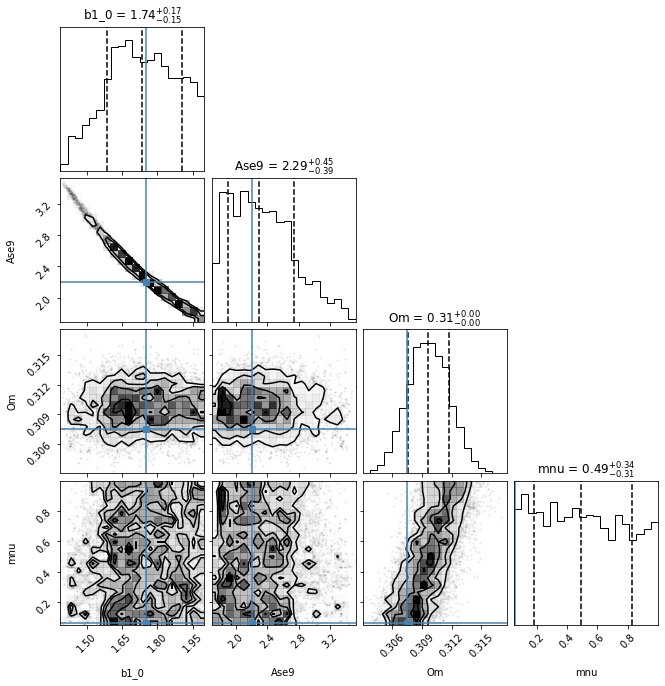

distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
08:53:43 ERROR:_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
asyncio.exceptions.CancelledError


In [34]:
_ = corner(outp['chain'],quantiles=[0.16, 0.5, 0.84],
                       title_kwargs={"fontsize": 12}, show_titles=True,
          labels=params_order,
          truths=[1.75, 2.2, .3075, 0.06])
plt.plot()